<a href="https://colab.research.google.com/github/Pugianf/Big_Data_and_Public_Sector_III-Economic_Development/blob/main/Aula_6_2021_12_14_CAPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas

# Finanças: *Capital Asset Pricing Model* (CAPM)


---

In [ ]:
## Instalando biblioteca para pegar os dados dos ativos (ações)
from IPython.display import clear_output

!pip install yfinance  # Yahoo Finance
!pip install ipeadatapy  # dados do ipeadata (vamos usar para coletar risco-país)

clear_output()

In [ ]:
## Importando o que for necessário
# Manipulação e Coleta de Dados
import ipeadatapy
import yfinance as yf
import pandas as pd
import numpy as np

# Testes e regressões
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import matplotlib.ticker as mtick

style.use('ggplot')  # estilo do R

## Leitura e Limpeza dos Dados

### Leitura e Limpeza

Vamos usar a biblioteca do Yahoo para baixar os dados de ações. Por isso, nem precisamos montar o nosso Drive!

In [ ]:
## Baixando os dados dos últimos 12 anos (12y) por mês (1mo)
# Na biblioteca, os tickers (códigos das ações) são separados por espaços
# AAPL: Apple; MSFT: Microsoft; PBR: Petrobras; IBM: IBM;
# Além deles, também queremos o índice S&P500 geral (^GSPC)
# group_by: os tickers estarão nas colunas
data = yf.download(tickers='^GSPC AAPL MSFT PBR IBM', period='12y', interval='1mo', group_by='ticker')

# Vendo o DataFrame
data

# Resultado muito feio! Temos que arrumar e limpar os dados

In [ ]:
## Retirando linhas com valores nulos
data.dropna(axis=0, inplace=True)

## Vendo resultado
data

In [ ]:
## Agora, vamos deixar nosso df apenas com a coluna de preço que nos interessa: o preço de fechamento ajustado da ação

# Primeiro, vamos colocar o segundo nível do MultiIndex das colunas nas linhas
data = data.stack(level=1).rename_axis(['Data', 'Preço'])
data

In [ ]:
## Vamos usar o query para selecionar apenas as linhas com Adj Close
data.query("Preço == 'Adj Close'", inplace=True)
data

In [ ]:
## Por fim, vamos droppar o index de preço
data = data.droplevel(level=1)
data

### Ações como Passeios Aleatórios?

Lembrando da aula da 1ª disciplina de Séries de Tempo, comentamos que um exemplo clássico de passeio aleatório com deslocamento são os preços de ações.

Relembrando, uma série é um passeio aleatório se ela for não-estacionária (média e variância não-constante no tempo) e possuir correlação serial.

Em termos de equação, 

\begin{align*}
Y_t = \phi Y_{t-1} + \epsilon_t
\end{align*}

onde $\phi$ é **diferente de zero** (há correlação serial/autocorrelação) e $\epsilon_t$ é um termo de erro que segue uma distribuição aleatória normal.

Diferentemente de um ruído branco ou de uma série estacionária, sua média é diferente de 0 e possui uma variância não constante.

Contudo, sua diferenciação gera um ruído branco ($\epsilon_t$).

In [ ]:
## Importando funções de série de tempo
from statsmodels.tsa.stattools import adfuller  # teste de estacionariedade
from statsmodels.graphics.tsaplots import plot_acf  # autocorrelação

In [ ]:
## Plottando (deixando de fora o S&P500 porque ele está muito fora de escala)
data[["AAPL", "IBM", "MSFT", "PBR"]].plot()

In [ ]:
## Criando um passeio aleatório com deslocamento
# Veja como o comportamento volátil das curvas tende a ser parecido!

# Valor inicial 0
passeio = [0]

## Criando valores
for i in range(data.shape[0]):
    # Criando o erro aleatório: random fornece um valor aleatório entre 0 e 1
    # Se menor que 0.5, diminuir 1, caso contrário, somar 1
    erro = -1 if np.random.random() < 0.5 else 1
    passeio.append(passeio[-1] + erro)

## Adicionando o deslocamento a cada etapa
passeio_deslocamento = pd.Series(passeio) + 5

## Plottando a série e sua média
plt.plot(passeio_deslocamento)
plt.hlines(y=np.mean(passeio_deslocamento), xmin=0, xmax=data.shape[0], color='red')
print(f"Média: {np.around(np.mean(passeio_deslocamento), 2)}")

In [ ]:
## Plottando a série da ação desejada e sua média
# Calculando média
sAcao = "PBR"
nMedia = np.mean(data[sAcao])

# Plottando
plt.plot(np.array(data[sAcao]))
plt.hlines(y=nMedia, xmin=0, xmax=data.shape[0], color='blue')
print(f"Média: US$ {np.around(nMedia, 2)}")

In [ ]:
## Vendo se há autocorrelação
plot_acf(data[sAcao], lags=12)

In [ ]:
## Testando estacionariedade usando o teste Aumentado de Dickey-Fuller
resultado_adf = adfuller(data[sAcao])
print(f"P-valor do teste: {resultado_adf[1]}")
print("H0: a série NÃO é estacionária e possui raiz unitária.")

# Se p < 0.05, a série é estacionária

## AAPL, MSFT e ^GSPC são com certeza não-estacionárias (p-valor de 1)
## PBR tem p-valor de 0,17, enquanto IBM se comporta como estacionária

## Retornos

In [ ]:
## Calculando os retornos percentuais de cada ação
# dropna(): excluindo o valor nulo da primeira data
dfRetornos = data.pct_change().dropna()

## Vendo resultado
dfRetornos

In [ ]:
## Plottando
# Tudo em um só gráfico
ax = dfRetornos.plot(figsize=(10, 10))

## Colocando eixo y em porcentagem
# O jeito é diferente do da aula passada porque estamos usando o .plot() do pandas
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Petrobras é para os fortes! Muito volátil e parece ter sofrido muito com a pandemia

In [ ]:
# Separado
ax = dfRetornos.plot(subplots=True, figsize=(10, 10))

In [ ]:
## Vendo estatísticas descritivas
dfRetornos.describe()

Na média, a IBM teve o menor retorno mensal, mas é seguida de perto pela Petrobras.
Na outra ponta, AAPL e MSFT tiveram retornos médios de 2% a.m.!

Além disso, PBR tem de longe o maior desvio padrão, sendo, portanto, mais volátil e arriscada. Além disso, houve um mês em que ela caiu mais de 54%!

Como esperado, o ^GSPC - por ser um índice de várias ações - tem a menor volatildade, o que evidencia na prática o princípio da diversificação.

Além disso, note que todas as ações tiveram retorno médio positivo durante o período!

## Índice de Sharpe

Vemos que há os retornos da MSFT e da AAPL são muito parecidos, mas a AAPL tem um retorno médio e uma volatildade maior. 

Qual delas será que tem o maior retorno ajustado ao risco?

Vamos calcular o índice de Sharpe, dado por

$ IS = \frac{E(Retorno) - r_f}{\sigma_{Retorno}}, $

onde $E(Retorno)$ é a média dos retornos, $r_f$ é a taxa livre de risco (geralmente, títulos públicos) e $\sigma_{Retorno}$ é o desvio-padrão do retorno.

In [ ]:
## Como vimos acima, precisamos da taxa livre de risco
# Ela é definida como a média dos retornos diários dos títulos do tesouro 
# americano de 10 anos de maturidade (^TNX)

# Caso estivéssemos avaliando empresas em território brasileiro, o ideal é somar
# ao ^TNX uma medida de risco-Brasil, como o CDS ou o EMBI+Brasil
# Atenção: NUNCA NUNCA NUNCA usar Selic como taxa livre de risco no Brasil
  # 1. Brasil já teve moratória
  # 2. Selic é a taxa de curto prazo; pode-se, porém, usar alguma taxa pré-fixada longa do Tesouro Direto,
      # que pode ser encontrada no site do Tesouro Transparente

# Coletando os dados do yield (retorno) tesouro norte-americano de 10 anos
dfTesouroUS = yf.download(tickers='^TNX', start="2010-02-01", interval='1d')
dfTesouroUS = dfTesouroUS[["Adj Close"]].copy()  # apenas dados do fechamento ajustado

# Resultado
dfTesouroUS.head()

In [ ]:
## Os dados acima estão em % anuais: em 1º de fevereiro de 2010, o título
## estava pagando cerca de 3,654% ao ano
# Dividindo por 100 para deixar a porcentagem no formato numérico
dfTesouroUS["Adj Close"] = dfTesouroUS["Adj Close"] / 100

## Por fim, precisamos mensalizar os retornos anuais
## Faremos isso tirando a raiz decima segunda!
dfTesouroUS["Adj Close"] = (1 + dfTesouroUS["Adj Close"]) ** (1 / 12) - 1

# Vendo resultado
dfTesouroUS.head()

# Pagar 3,65% a.a. -> pagar 0,29% a.m. (levando em conta juros compostos)

In [ ]:
## Vamos calcular o Índice de Sharpe!
# Médias e desvio-padrão de cada coluna
vMedias = np.array(np.mean(dfRetornos, axis=0))
vDesvPads = np.array(np.std(dfRetornos, axis=0))

# Taxa livre de risco
nTaxaLivreRisco = np.array(np.mean(dfTesouroUS["Adj Close"]))
print(f"TLR: {100 * np.around(nTaxaLivreRisco, 4)}% ao mês.")

# Criando DataFrame
dfSharpe = pd.DataFrame(
    data=(vMedias - nTaxaLivreRisco) / vDesvPads,
    columns=["Índice_Sharpe"],
    index=dfRetornos.columns
)
dfSharpe

A ação de pior retorno ajustado ao risco é a IBM, uma vez que seu retorno é muito baixo (cerca de 2/3 o da PBR).

A melhor ação é a AAPL, enquanto o ^GSPC (S&P500) se mostra uma boa opção: menor retorno, mas também menor risco.

Em Finanças mais avançadas, tem-se por objetivo escolher uma carteira de investimentos com composições e montante investido que maximiza o Índice de Sharpe (maximiza o retorno levando em contas os riscos).
Na área de finanças quantitativas, essa é conhecida como a **carteira tangente**.

## CAPM

O Índice de Sharpe analisa como se dá a escolha de investimento e da carteira de um investidor, dadas as informações sobre o preço e o retorno dos ativos.

Por sua vez, o **CAPM**, como o nome diz, a analisa como os ativos de capital e os seus retornos esperados são **precificados**.

Além de ser usado para escolhas de investimento, o CAPM é usado para fornecer taxas de retorno de referência e taxas de desconto para a avaliação de possíveis de investimentos e regulações. 

De fato, o Ministério da Economia usa uma metodologia modificada do CAPM para a [precificação e leilão de concessões públicas]( https://www.gov.br/fazenda/pt-br/centrais-de-conteudos/publicacoes/guias-e-manuais/metodologia-de-calculo-do-wacc2018.pdf/view).

Matematicamente, a equação fundamental do CAPM é:

\begin{align*}
E(R_{it}) = \alpha_i^* r_f + \beta_i [E(R_M) - r_f],
\end{align*}

onde $E(R_{it})$ é o retorno esperado do ativo $i$ no período $t$, $r_f$ é a taxa livre de risco e $E(R_M)$ é o retorno do mercado (dado pelo índice S&P500 ou pelo IBOVESPA no Brasil).

Pode-se mostrar que o parâmetro $\beta_i$ pode ser encontrado via um estimador de mínimos quadrados ordinários, ou seja, ele é da forma

\begin{align*}
\beta_i = \frac{Cov(R_{it}, R_M)}{Var(R_M)}
\end{align*}

Intuitivamente, a equação do CAPM diz que o preço esperado de um ativo é formado a partir de três componentes:

- O *preço do tempo*, dado por $r_f$. Como, em tese, o ativo livre de risco não possui risco, seu custo e retorno estão inteiramente ligados à perda de liquidez por parte do investidor;

- O *excesso de retorno do mercado de ativos*, dado por $E(R_M) - r_f$;

- A *quantidade do risco*, dada por $\beta_i$.

Por fim, $\alpha_i^*$ é um parâmetro que mede o quanto o valor esperado do retorno é maior que o predito pelo CAPM. Se $\alpha_i^* > 0$, o preço estaria mais baixo e valeria a pena comprar o ativo.

### Correlação entre Retornos Individuais e do Mercado

In [ ]:
## Vendo a relação dos retornos da AAPL com os retornos de mercado
sns.regplot(x="^GSPC", y="AAPL", data=dfRetornos)

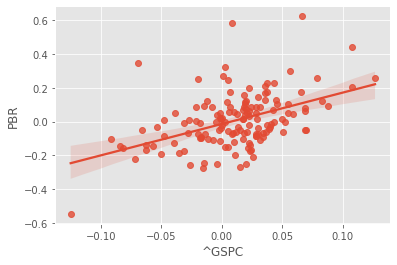

In [ ]:
## Vendo a relação do PBR com os retornos de mercado
# Note com a reta é menos inclinada
sns.regplot(x="^GSPC", y="PBR", data=dfRetornos)

OBS: geralmente, ativos ditos *de proteção* possuem uma correlação com o mercado ($\beta_i$) negativa, como é o caso do ouro e da prata.

### Estimando Equações do CAPM

In [ ]:
## Primeiramente, nossos dados de ações estão em intervalos mensais,
## enquanto nossa taxa livre de risco está em intervalos diários

## Vamos pegar a média mensal dos yields do tesouro americano
# Coluna de Mês e Ano
dfTesouroUS["Mes_Ano"] = dfTesouroUS.index.to_period('M')

# Taxa média por mês
dfTesouroUSMensal = dfTesouroUS.groupby("Mes_Ano")[["Adj Close"]].mean()

# Renomeando
dfTesouroUSMensal.rename(columns={"Adj Close": "T10y"}, inplace=True)

In [ ]:
## Resultado
dfTesouroUSMensal.head()

In [ ]:
## Juntando ao DataFrame de retornos
dfRetornos1 = pd.concat((dfRetornos.reset_index(), dfTesouroUSMensal.reset_index()), axis=1)
dfRetornos1

In [ ]:
## Para deixar consistente, vamos retirar a última linha
dfRetornos1.dropna(axis=0, inplace=True)

In [ ]:
## Coluna de excesso de retorno
dfRetornos1["ExcessoRetornoMercado"] = dfRetornos1["^GSPC"] - dfRetornos1["T10y"]

## Resultado
dfRetornos1

In [ ]:
## Criando formula para o CAPM
sAcaoVarDependente = "AAPL"
formula_capm = f"{sAcaoVarDependente} ~ 1 + T10y + ExcessoRetornoMercado"

## Modelo com covariância robusta
modelo_capm = ols(formula=formula_capm, data=dfRetornos1).fit(
    cov_type='HC1',
    use_t=True
)

## Sumário
print(modelo_capm.summary())

# Como a taxa livre de risco tende a ser pequena e sofrer pouca variação,
# ela é insignificante e poderia ser retirada do modelo para evitar multicolinearidade
# com o componente de excesso (o statsmodels até dá um aviso de que há esse problema)

# O intercepto, que capta o termo alfa, é insignificante; 
# na média, a ação não está sobre/subvalorizada e o CAPM parece ser um bom modelo
# para explicar seu preço


# No caso da AAPL, seu Beta é de 1,1 e é maior que 1; logo, ela reage mais que proporcionalmente ao mercado

O CAPM ainda é capaz de ser utilizado para explicar a formação de preços de ativos, como vimos acima.

Contudo, fica a ressalva de que existem modelos mais complexos que levam em consideração impostos, custos de transação, assimetrias de informação e irraconalidade (comportamentos de manada, por exemplo).

## Análise da Bolsa Brasileira

### Dados

In [ ]:
## Baixando os dados dos últimos 12 anos (12y) por mês (1mo)
# ^BVSP: índice IBOVESPA, que capta as principais ações do mercado brasileiro
# ITSA3: Itaú (3: ação ordinária; 4: preferencial)
# PETR3: Petrobras (listada na bolsa brasileira)
# SGPS3: Springs Global (varejo)
# GOLL: gol linhas aéreas
# MGLU: Magazine Luiza
# .SA: sociedade aberta
dataBrasil = yf.download(tickers='^BVSP ITSA3.SA PETR3.SA SGPS3.SA GOLL4.SA MGLU3.SA', 
                         period='12y', interval='1mo', group_by='ticker')

# Vendo o DataFrame
dataBrasil

In [ ]:
#### Limpando o DataFrame seguindo o mesmo procedimento acima
## Retirando linhas com valores nulos
dataBrasil.dropna(axis=0, inplace=True)

## Pegando apenas Adj Close
dataBrasil = dataBrasil.stack(level=1).rename_axis(['Data', 'Preço'])
dataBrasil.query("Preço == 'Adj Close'", inplace=True)

## Por fim, vamos droppar o index de preço
dataBrasil = dataBrasil.droplevel(level=1)

# Resultado
dataBrasil

In [ ]:
## Plottando (deixando de fora o BVSP porque ele está fora de escala)
dataBrasil[["ITSA3.SA", "PETR3.SA", "SGPS3.SA", "GOLL4.SA", "MGLU3.SA"]].plot()

# MGLU3 teve uma subida de preço gigante, mas começou a cair a partir de meados de 2021
# GOLL3 sofreu emais com a pandemia, enquanto PETR3 já se recuperou

### Retornos

In [ ]:
## Calculando os retornos percentuais de cada ação
# dropna(): excluindo o valor nulo da primeira data
dfRetornosBrasil = dataBrasil.pct_change().dropna()

## Vendo resultado
dfRetornosBrasil

In [ ]:
## Estatisticas descritivas
dfRetornosBrasil.describe()

# GOLL4 e MGLU são as mais voláteis
# MGLU já chegou a quase dobrar de preço em mês
# GOL e SGPS já perderam mais da metade do valor em um mês

In [ ]:
## Calculando os retornos cumulativos de cada ação usando o cumprod() (cumulative product)
# EUA
dfRetornosCumulativos = (1 + dfRetornos).cumprod() - 1

# Brasil
dfRetornosCumulativosBrasil = (1 + dfRetornosBrasil).cumprod() - 1

# Resultado
dfRetornosCumulativosBrasil.tail()

In [ ]:
## Plottando Brasil
dfRetornosCumulativosBrasil.plot()

# Bem... investir no MGLU3 em 2010 talvez fosse uma boa; o dinheiro teria multiplicado em mais de 50x no topo!

In [ ]:
# Plottando EUA
dfRetornosCumulativos.plot()

In [ ]:
## Comparando os retornos da bolsa brasileira (^BVSP) e da americana (^GSPC) desde 2010
dfRetornosBolsas = dfRetornosCumulativos.merge(dfRetornosCumulativosBrasil, how="inner", left_index=True, right_index=True)

# Selecionando apenas os índices
dfRetornosBolsasIndices = dfRetornosBolsas[["^GSPC", "^BVSP"]].copy()

# Plottando
dfRetornosBolsasIndices.plot()

# Vendo valores do último mês
dfRetornosBolsasIndices.tail(1)

# Desde 2010, a bolsa brasileira rendeu cerca de 73% (investiu 100, tá com 173)
# A bolsa americana, por sua vez, rendeu 334% (investiu 100, tá com 434)
# Brasil estagnado, principalmente no pós-pandemia (veja a inclinação das curvas)

# Lembrando: os preços de ações são formados a partir de expectativas; se o índice brasileiro
# não subiu tanto quanto o americano, os investidores não esperam bom desenho da nossa economia
# no futuro próximo

### Índice de Sharpe

In [ ]:
## Precisamos da taxa livre de risco brasileira; como vimos acima, podemos adicionar
## uma medida de risco-país a taxa livre de risco americana, que é o que faremos aqui

## Vamos usar o EMBI+, coletado a partir do site do ipeadata (http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=40940&module=M)
## Ele é medido em pontos-base (100 pb = 1%); por isso, vamos dividi-lo por 10.000 posteriormente
dfEMBI = ipeadatapy.timeseries('JPM366_EMBI366', yearGreaterThan=2010)
dfEMBI

In [ ]:
## Pegando apenas as colunas relevantes
# Criando uma coluna de Mes_Ano
dfEMBI["Mes_Ano"] = dfEMBI.index.to_period('M')

# Selecionando colunas relevantes
dfEMBI = dfEMBI[["Mes_Ano", "VALUE (-)"]].copy()

## Renomeando coluna de valor e dividindo por 10000
dfEMBI.rename(columns={"VALUE (-)":"EMBI"}, inplace=True)
dfEMBI["EMBI"] = dfEMBI["EMBI"] / 10000

## Droppando nans
dfEMBI.dropna(axis=0, inplace=True)

## Resultado
dfEMBI

# Em 2011, o risco Braisl era de 1,81% a.a. (ou seja, para valer a pena para um
# investidor internacional investir aqui, ele teria de receber 1,81% a mais
# do que nos EUA para compensar o risco)

In [ ]:
## Comportamento do risco país
dfEMBI[["EMBI"]].plot()

In [ ]:
## Vamos mensalizar a taxa do EMBI
dfEMBI["EMBI"] = (1 + dfEMBI["EMBI"]) ** (1 / 12) - 1

## Vamos pegar a média mensal para somar yields do tesouro americano
dfEMBIMensal = dfEMBI.groupby("Mes_Ano")[["EMBI"]].mean()

## Juntando ao dataframe com os dados mensais do tesouro americano
dfTesouroUSEMBI = dfEMBIMensal.merge(dfTesouroUSMensal, how="inner", on="Mes_Ano")

dfTesouroUSEMBI

In [ ]:
## Como nossos dados de retornos começam em julho de 2011, vamos pegar apenas esses dados
dfTesouroUSEMBI.query("Mes_Ano > '2011-06'", inplace=True)

## Somando as taxas
dfTesouroUSEMBI["TLR_Brasil"] = dfTesouroUSEMBI["T10y"] + dfTesouroUSEMBI["EMBI"]

## Resultado
dfTesouroUSEMBI

In [ ]:
## Vamos calcular o Índice de Sharpe!
# Médias e desvio-padrão de cada coluna
vMedias = np.array(np.mean(dfRetornosBrasil, axis=0))
vDesvPads = np.array(np.std(dfRetornosBrasil, axis=0))

# Taxa livre de risco
nTaxaLivreRisco = np.array(np.mean(dfTesouroUSEMBI["TLR_Brasil"]))
print(f"TLR: {100 * np.around(nTaxaLivreRisco, 4)}% ao mês.")

# Criando DataFrame
dfSharpe = pd.DataFrame(
    data=(vMedias - nTaxaLivreRisco) / vDesvPads,
    columns=["Índice_Sharpe"],
    index=dfRetornosBrasil.columns
)
dfSharpe

# MGLU ainda é de longe a melhor, seguida pela GOLL (apesar de volátil, tem um retorno médio grande)

In [ ]:
## Relembrando estatísticas
dfRetornosBrasil.describe()

### CAPM

In [ ]:
## Correlação entre ativo e a BOVESPA
sAcaoBrasil = "MGLU3.SA"

sns.regplot(x="^BVSP", y="MGLU3.SA", data=dfRetornosBrasil)

In [ ]:
## Juntando a taxa livre de risco ao DataFrame de retornos
dfRetornosBrasil = pd.concat((dfRetornosBrasil.reset_index(), dfTesouroUSEMBI.reset_index()), axis=1)

## Coluna de excesso de retorno
dfRetornosBrasil["ExcessoRetornoMercado"] = dfRetornosBrasil["^BVSP"] - dfRetornosBrasil["TLR_Brasil"]

## Resultado
dfRetornosBrasil

In [ ]:
## Retirando os .SA das colunas (atrapalha na escrita da fórmula)
dfRetornosBrasil.rename(columns={
    "GOLL4.SA":"GOLL4",
    "ITSA3.SA":"ITSA3",
    "MGLU3.SA":"MGLU3",
    "PETR3.SA":"PETR3",
    "SGPS3.SA":"SGPS3"
}, inplace=True)

In [ ]:
## Criando formula para o CAPM
# Dessa vez, vamos deixar de fora o componente da taxa livre de risco (insignificante e causa multicolinearidade)
sAcaoVarDependente = "ITSA3"
formula_capm = f"{sAcaoVarDependente} ~ 1 + ExcessoRetornoMercado"

## Modelo com covariância robusta
modelo_capm = ols(formula=formula_capm, data=dfRetornosBrasil).fit(
    cov_type='HC1',
    use_t=True
)

## Sumário
print(modelo_capm.summary())

# No caso da ITSA, o CAPM é bom em prever seu preço (intercepto negativo) e seu Beta é de 0,78
# (reage menos proporcionalmente ao mercado). No caso da MGLU, é o contrário: Beta é maior que um (1,22),
# ou seja, ela reage mais que proporcionalmente aos retornos do mercado

# Obrigado!